# <b> Payment Date Predictionm</b>

In [5]:
#importing all the libraries 
import numpy as np
import pandas as pd
import datetime as dt
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Machine Learning libraries  
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import sklearn.metrics as metrics
import xgboost as xg

# Machine Learning Part of B2B Order Management Application 


Through this model we have tried to predict the date of payment and aging bucket of an invoice from the invoice creation. The whole purpose of the model is to help the account receivel team in the payment processs from the past Experiences 
<br>
<br>
Similar to any machine learning project it is a kind of supervised probelm and we have applied regression for the purpose
<br>
Here is the Workflow of the Whole Process.
<br> 
<a id='starting'></a>
1. [Dataset](#dataset) 
2. [Preprocessing](#preprocessing) 
3. [EDA and Data Visualization](#eda)
4. [Feature Selection](#feature)
5. [Machine Learning Algorithms](#ml)
6. [Hyperparameters tunning](#Hyper) 
7. [Model Selection](#model)
8. [Mapping](#Mapping) 

![Aman](flow.png)

<a id='dataset'></a>
# <b>1.Dataset and Data Cleaning</b> 

### <b> Observation</b>

* There is a Duplicate available in dataset named 'document_create_date.1' 
* There is also rows available in the dataset that is missing large number of value i.e clear_date,area_business so we dropped these rows
* Two more thing thing that is noticeable  is <b> date and Currency </b> is not in well formeted 
* Most important we have also found ou the target variablle that is delay in dates for the invoice that is Generated

* Go to [Flowchart](#starting)

In [1]:
def load_data(notebook_name):
    " should be working in the same path "
    import os
    path= os.getcwd()
    print("currently working in "+ str(os.listdir()))
    path= os.getcwd()
    data = pd.read_csv(os.getcwd()+"//"+notebook_name)
    df = pd.DataFrame(data)
    return data


In [2]:
df = load_data("data.csv") 

df.columns

currently working in ['.ipynb_checkpoints', '.vscode', 'data.csv', 'experiment.csv', 'first.csv', 'flow.png', 'Invoice management system.ipynb', 'ml_copy-Copy1.ipynb', 'Modeling_assignment.ipynb', 'my_work.ipynb', 'Payment date prediction.ipynb', 'Payment date2.ipynb', 'rough.ipynb']


NameError: name 'pd' is not defined

In [ ]:
df.shape

In [ ]:
df.info()

In [ ]:
df.describe()

## Data Cleaning 

In [ ]:
# top 5 record
df.head(5)

In [ ]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
(percent_missing)

In [ ]:
df.isna().sum()

In [ ]:
## mostly the Invoice_id and Dov is are same 
a = (df["invoice_id"]== df["doc_id"])
a.value_counts()

In [ ]:
## Duplicates
df_1 = df.drop(['document_create_date.1'], axis=1)

# finding nan values 
df_1.isna().sum()

In [ ]:
## instruction are given to drop multiple column but i wanted to analyse 
## and then drop it 

#area has overall all the null value hence dropping 
df_1 = df_1.drop(['area_business'], axis = 1)

#similar to tarea buisenss clear date is having atmost to many null  value 
# but it is essential for finding targer payment 
# hence we are dropping only null value 
df_1 = df_1.dropna(axis = 0, how ='any')
df_1.shape


In [ ]:
df_1.isna().sum()

In [ ]:
df_1[:10]

<a id='preprocessing'></a>
# <b> 2.  Preprocessing </b>

* In preprocessing we have done some simple steps like 
data cleaning, data integration, data reduction, and data transformation

    1.  converting cad amount into usd 
    2.  formetting date into proper formet 
    3.  then we created train and test with making target column
        * for <b> target variable </b> we have just subtracted clear_date with due_date 

## 2.1 remember to convert amount into usd  

In [ ]:

## Drop the IDEa to convert it 
currecy = (df["invoice_currency"])

usd,cad = 0,0
for i in range(len(currecy)):
    if(currecy[i]=="USD"):
        usd+=1
    elif(currecy[i]=="CAD"):
        cad +=1 
print(usd,cad)      
        

## 2.2 Formatting Date 

In [ ]:
def change_date(x_type):
    x = int(x_type)
    x = str(x)
    year = int(x[0:4])
    month = int(x[4:6])
    day = int(x[6:])
    return dt.datetime(year, month, day)

In [ ]:
print(type(change_date(20200210.0)))
print(change_date(20200210.0))

 ## 2.3 Creating Target Varible 

In [3]:
df_1['due_date'] = df_1['due_in_date'].apply(change_date)
df_1['clear_date']= pd.to_datetime(df_1['clear_date']) 

# target variable
df_1['target'] = (df_1['clear_date'] - df_1['due_date']).dt.days

NameError: name 'df_1' is not defined

In [13]:
## just applied in the proper formet

df_1['document_create_date'] = df_1['document_create_date'].apply(change_date)
df_1['baseline_create_date'] = df_1['baseline_create_date'].apply(change_date)
df_1['due_in_date'] = df_1["due_in_date"].apply(change_date)

### The Positive value means that there is delay in payment and negation means it is paid 

In [14]:
df_1["target"][:10]

0      1
1     -3
2     92
4     -3
5     61
6     -4
8     -4
9     -1
11     5
12     6
Name: target, dtype: int64

In [15]:
df_1[:5]

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,due_in_date,invoice_currency,document type,posting_id,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen,due_date,target
0,U001,0200769623,WAL-MAR corp,2020-02-11,2020.0,1.930438e+09,2020-01-26,2020-01-25,2020-02-10,USD,RV,1.0,54273.28,2020-01-26,NAH4,1.930438e+09,0,2020-02-10,1
1,U001,0200980828,BEN E,2019-08-08,2019.0,1.929646e+09,2019-07-22,2019-07-22,2019-08-11,USD,RV,1.0,79656.60,2019-07-22,NAD1,1.929646e+09,0,2019-08-11,-3
2,U001,0200792734,MDV/ trust,2019-12-30,2019.0,1.929874e+09,2019-09-14,2019-09-14,2019-09-29,USD,RV,1.0,2253.86,2019-09-14,NAA8,1.929874e+09,0,2019-09-29,92
4,U001,0200769623,WAL-MAR foundation,2019-11-25,2019.0,1.930148e+09,2019-11-13,2019-11-13,2019-11-28,USD,RV,1.0,33133.29,2019-11-13,NAH4,1.930148e+09,0,2019-11-28,-3
5,CA02,0140106181,THE corporation,2019-12-04,2019.0,2.960581e+09,2019-09-20,2019-09-20,2019-10-04,CAD,RV,1.0,22225.84,2019-09-24,CA10,2.960581e+09,0,2019-10-04,61


In [16]:
# Splitting the initial dataframe into train and test
# So in this case we can consider last 3 months for test set.
x_train = df_1[df_1['document_create_date'] <= '2020-01-01'].copy()
x_test = df_1[df_1['document_create_date'] > '2020-01-01'].copy()

In [17]:
x_test.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,due_in_date,invoice_currency,document type,posting_id,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen,due_date,target
0,U001,0200769623,WAL-MAR corp,2020-02-11,2020.0,1.930438e+09,2020-01-26,2020-01-25,2020-02-10,USD,RV,1.0,54273.28,2020-01-26,NAH4,1.930438e+09,0,2020-02-10,1
19,U001,0200769623,WAL-MAR systems,2020-02-05,2020.0,1.930438e+09,2020-01-24,2020-01-24,2020-02-08,USD,RV,1.0,53349.54,2020-01-24,NAH4,1.930438e+09,0,2020-02-08,-3
20,U013,0100053554,SYSTEMS systems,2020-02-11,2020.0,1.991838e+09,2020-01-11,2020-01-07,2020-02-10,USD,RV,1.0,5683.50,2020-01-11,NAVE,1.991838e+09,0,2020-02-10,1
24,U001,0200769623,WAL-MAR co,2020-02-04,2020.0,1.930431e+09,2020-01-24,2020-01-23,2020-02-08,USD,RV,1.0,11307.78,2020-01-24,NAH4,1.930431e+09,0,2020-02-08,-4
41,U001,0200769623,WAL-MAR associates,2020-01-21,2020.0,1.930353e+09,2020-01-04,2020-01-04,2020-01-19,USD,RV,1.0,4953.83,2020-01-04,NAH4,1.930353e+09,0,2020-01-19,2


In [18]:
print(x_train.shape)
print(x_test.shape)

(34971, 19)
(5023, 19)


<a id='eda'></a>
# <b> 3. EDA </b> 
<br> 

* Through EDA We want to just watch certain data and see how our data is distributed
        1. First we want to look how how our buiseness are doing
        2. Invoice Currency 
        3. Payment is Done or Not 
        4. Document Type 
        5. Posting Id 
        6. Customer Payment Terms 
        7. 
* Go to [Flowchart](#starting)

## 3.1  Buisness Columns 
    1. In this section we just tried to understand how many buisness are there
    2. After comming from the currency a fundamental question arises which currency used in which buisnesss  and what were the buisness terms(revisted)
    

In [181]:
print(dict(x_train['business_code'].value_counts()))
print(dict(x_test['business_code'].value_counts()))

{'U001': 31589, 'CA02': 2820, 'U013': 442, 'U002': 107, 'U005': 9, 'U007': 4}
{'U001': 4601, 'CA02': 354, 'U013': 59, 'U002': 9}


<AxesSubplot:xlabel='business_code', ylabel='count'>

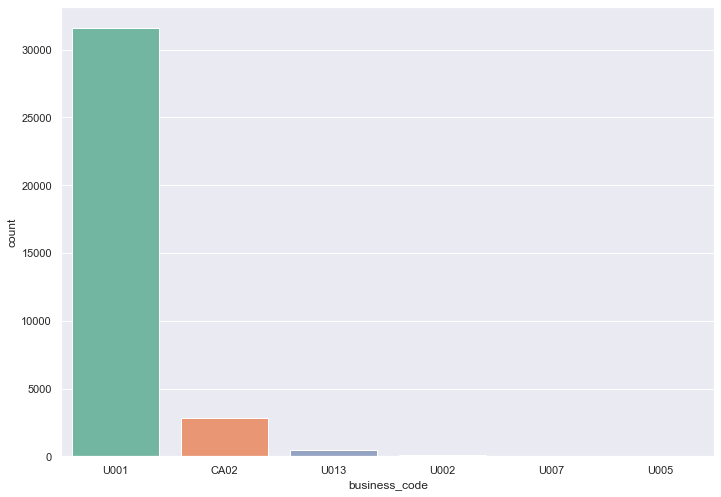

In [182]:
sns.set(style ="darkgrid")
sns.countplot(x = x_train['business_code'], palette = "Set2")

<AxesSubplot:xlabel='business_code', ylabel='count'>

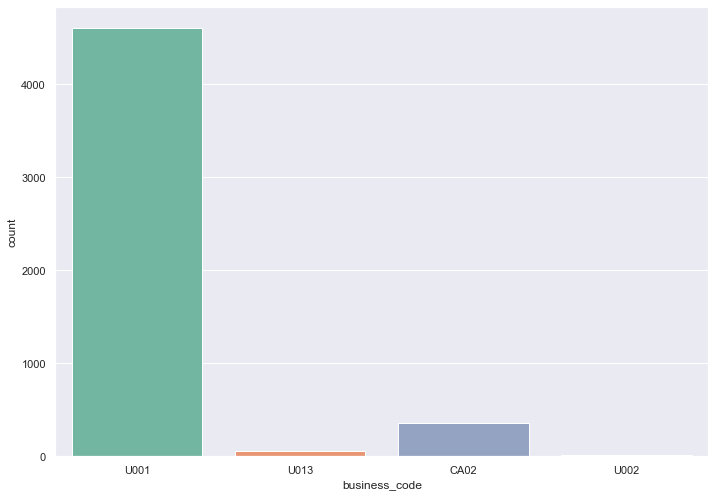

In [183]:
sns.countplot(x = x_test['business_code'], palette = "Set2")

In [184]:
# checking how our payment mode is distributed in buisnesses
x_train.groupby("business_code").invoice_currency.value_counts()

business_code  invoice_currency
CA02           CAD                  2820
U001           USD                 31589
U002           USD                   107
U005           USD                     9
U007           USD                     4
U013           USD                   440
               CAD                     2
Name: invoice_currency, dtype: int64

## 3.2 Invoice Currency 
1. We have first checked out the currency of the buisness 
2. Then we have tried to analyse currency used <b> per week and per Month </b> 
3. And further Analysis is Taken Into Payment Related Analysis


In [185]:
print(dict(x_train['invoice_currency'].value_counts()))
print(dict(x_test['invoice_currency'].value_counts()))

{'USD': 32149, 'CAD': 2822}
{'USD': 4669, 'CAD': 354}


<AxesSubplot:xlabel='invoice_currency', ylabel='count'>

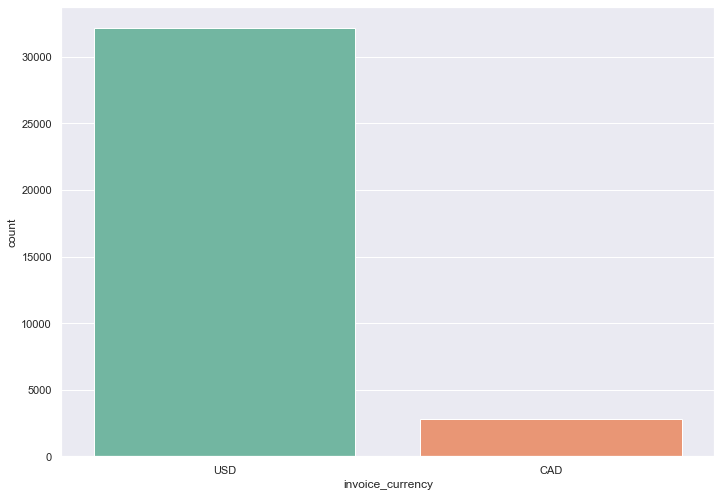

In [186]:
sns.countplot(x = x_train['invoice_currency'], palette = "Set2")

<AxesSubplot:xlabel='invoice_currency', ylabel='count'>

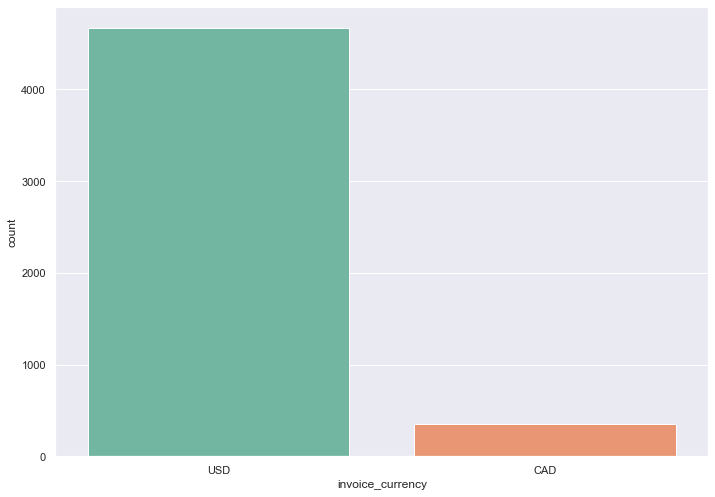

In [187]:
sns.countplot(x =x_test['invoice_currency'], palette = "Set2")

## 3.3 payment Related Observation
1. First We have checked out the unpaid amount that is available in out data 
2. Then we have  checked out again the payment status by month and week mostly it is equal apart from jan.
3. After Checking that we have seen how our open amount is distributed , from this we have observed that it is equally dist. 

In [188]:
# checking out the total number of open amount 
print(dict(x_train['isOpen'].value_counts()))
print(dict(x_test['isOpen'].value_counts()))

{0: 34971}
{0: 5023}


In [189]:
# open amount per month and Week 
clearPayment_month= x_train.clear_date.dt.month
clearPayment_week= x_train.clear_date.dt.week

clearPayment_month.value_counts().sort_values(axis = 0)

C:\Users\karti\AppData\Local\Temp\ipykernel_3600\1884036232.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  clearPayment_week= x_train.clear_date.dt.week


1     1587
2     2487
6     2803
9     2920
3     2962
7     3087
8     3103
11    3118
10    3144
12    3179
4     3191
5     3390
Name: clear_date, dtype: int64

<AxesSubplot:xlabel='clear_date', ylabel='count'>

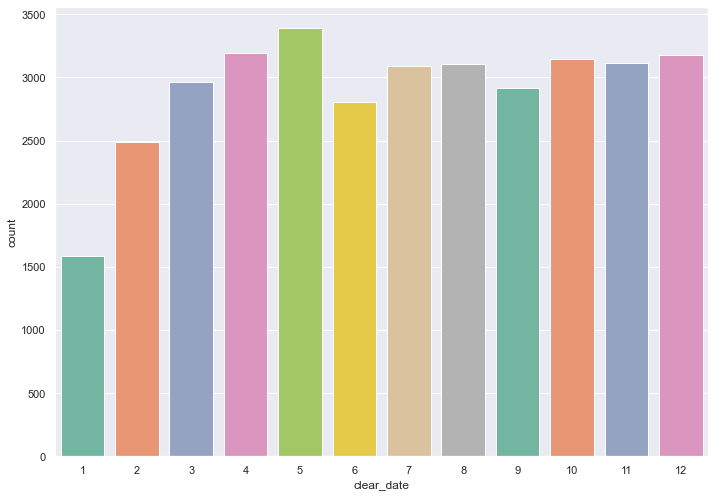

In [190]:
# jsut a simple visualization
sns.countplot(x= clearPayment_month,palette = "Set2")

In [191]:
clearnPayment_week =clearPayment_week.value_counts().sort_index()
# observe that the first is 

<AxesSubplot:xlabel='clear_date', ylabel='count'>

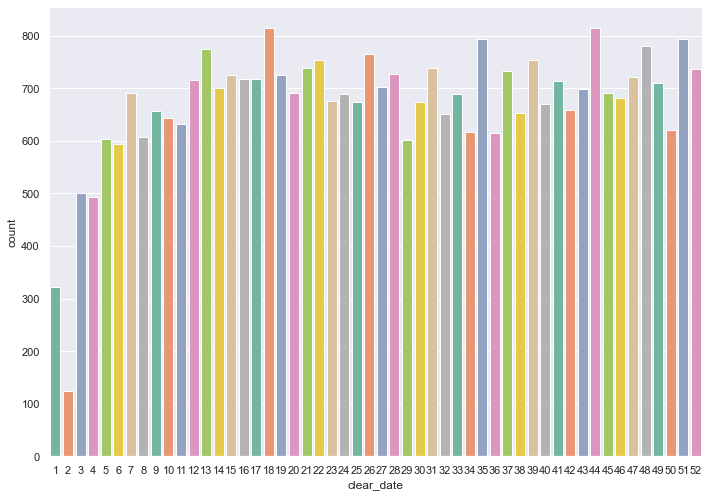

In [192]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot(x= clearPayment_week,palette = "Set2")

In [193]:
# here we have kinna of binnes the open amount into different 
# part to see how it is distributes and they all are same 
open_amount_for_bining = pd.qcut(x_train["total_open_amount"], q= 12)
open_amount_for_bining.value_counts()

(0.789, 617.712]          2915
(13710.213, 17319.71]     2915
(89531.078, 668593.36]    2915
(617.712, 1976.1]         2914
(1976.1, 4714.295]        2914
(4714.295, 8753.87]       2914
(8753.87, 13710.213]      2914
(17319.71, 23800.83]      2914
(23800.83, 34220.9]       2914
(34220.9, 46596.52]       2914
(46596.52, 61650.717]     2914
(61650.717, 89531.078]    2914
Name: total_open_amount, dtype: int64

In [194]:
## Again revisted 
# here we have shown how is the amount is realted to delay 
# if we are using automatic bins it is not working hence using manual bins
delay_days = [0,15,30,45,60,300]
delay_bucket = pd.cut(x_train['target'], bins=delay_days)   

binning = [0,5000,10000,20000, 40000,80000,160000, 320000]
amount_range = pd.cut(x_train['total_open_amount'], bins = binning )

In [195]:
print(pd.crosstab(index =amount_range, columns =delay_bucket))

target             (0, 15]  (15, 30]  (30, 45]  (45, 60]  (60, 300]
total_open_amount                                                  
(0, 5000]             2967        97        86        74         93
(5000, 10000]         1355        60        62        38         24
(10000, 20000]        2497       140       104        56         24
(20000, 40000]        2397        93        50        30         29
(40000, 80000]        2518        58        20         9         17
(80000, 160000]       1467        18        17         8          9
(160000, 320000]       230         4         1         2          0


<AxesSubplot:xlabel='total_open_amount', ylabel='count'>

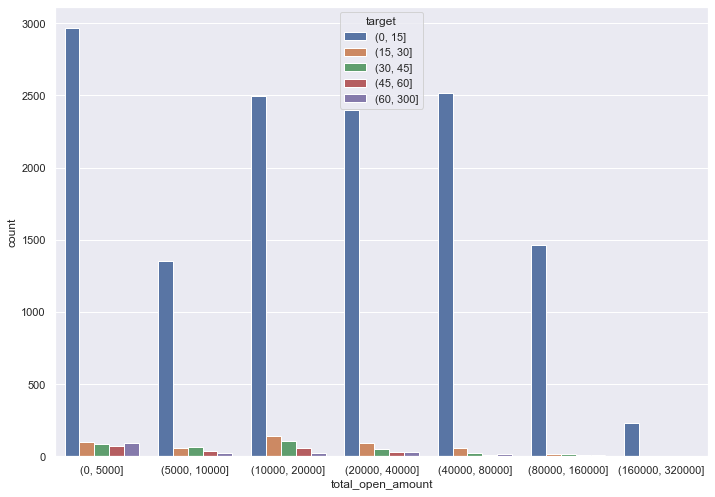

In [196]:
plt.xlabel("Amount bin")
sns.countplot(x = amount_range, hue=delay_bucket)

e:\conda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='total_open_amount', ylabel='Density'>

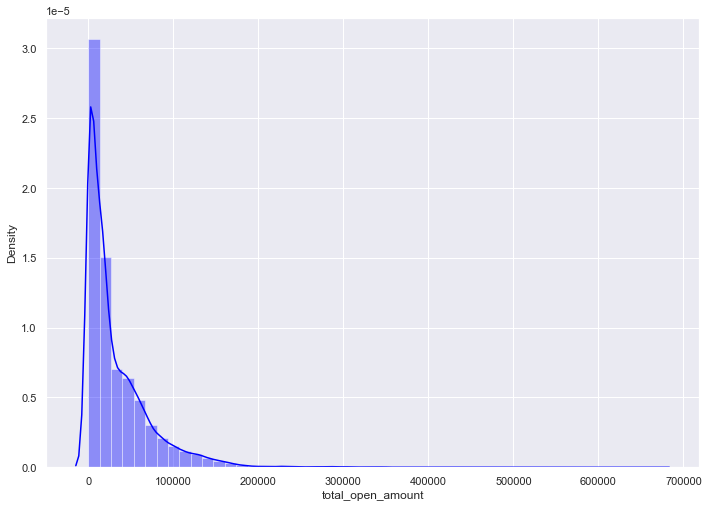

In [197]:
sns.distplot(x_train['total_open_amount'],color='blue')

In [198]:
# from countplot maybe total_open_amount is equally distributed 
# but the bell curve is  is heavly right skewed 
def transform(x):
    return np.log(x)

x_train['total_open_amount'] = x_train['total_open_amount'].apply(transform)
x_test['total_open_amount'] = x_test['total_open_amount'].apply(transform)

e:\conda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='total_open_amount', ylabel='Density'>

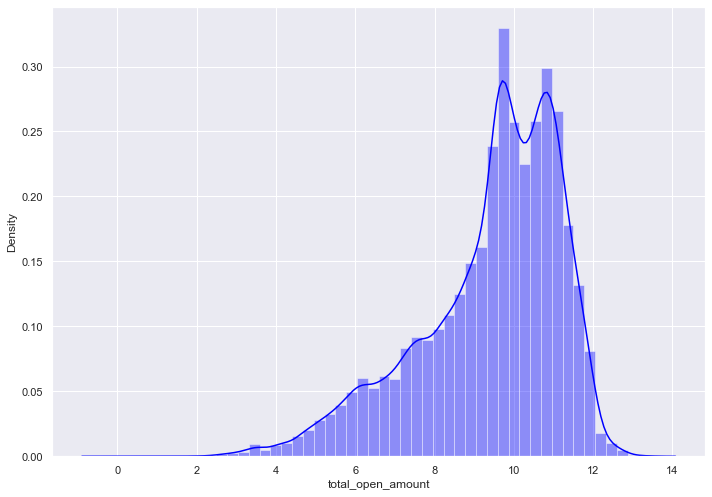

In [199]:
sns.distplot(x_train['total_open_amount'],color='blue')

## 3.4 Document Types 

In [200]:
print(dict(x_train['document type'].value_counts()))
print(dict(x_test['document type'].value_counts()))

{'RV': 34971}
{'RV': 5023}


## 3.5 Customer Payment Terms 

## <b> Observation</b> 
    * There are too many category hence we really need to find a way to group these element 
    * if we want to include in the features 
    * or other option is to drop it completely 

In [201]:
print(dict(x_train['cust_payment_terms'].value_counts()))
print("Testing Data")
print(dict(x_test['cust_payment_terms'].value_counts()))

{'NAA8': 14032, 'NAH4': 9267, 'CA10': 2727, 'NAC6': 1167, 'NAM4': 947, 'NAAX': 836, 'NAD1': 719, 'NAU5': 633, 'NAG2': 623, 'NAGD': 527, 'NA32': 526, 'NAX2': 469, 'NAM2': 418, 'NA10': 310, 'NAD5': 239, 'NAM1': 191, 'NAVE': 189, 'NAVF': 183, 'NAAW': 138, 'NAWU': 117, 'NAWN': 97, 'NAVR': 84, 'NAVQ': 75, 'NAWP': 48, 'CA30': 40, 'NAUZ': 37, 'NA3B': 36, 'NAVM': 31, 'NACB': 28, 'NA38': 23, 'NABG': 19, 'NAD4': 19, 'NAB1': 16, 'NAVD': 13, 'C106': 12, 'NA84': 12, 'NAVL': 11, 'BR56': 10, 'NAUP': 10, 'NA9X': 10, 'NA3F': 8, 'NATM': 7, 'NAM3': 6, 'CAB1': 6, 'CAX2': 5, 'NATJ': 5, 'NA25': 4, 'NAWM': 4, 'NATW': 4, 'B052': 3, 'NATH': 3, 'NAVC': 3, 'NA8Q': 3, 'NATL': 2, 'NAV9': 2, 'NATX': 2, '90M7': 2, 'NA31': 2, 'NATU': 1, 'NATK': 1, 'CA60': 1, 'NAUY': 1, 'NAUW': 1, 'NABD': 1, 'NATV': 1, 'MC15': 1, 'NAD8': 1, 'NAV2': 1, 'BR12': 1}
Testing Data
{'NAA8': 1984, 'NAH4': 1326, 'CA10': 342, 'NAM4': 165, 'NAC6': 150, 'NAAX': 126, 'NAGD': 119, 'NAG2': 100, 'NAD1': 100, 'NA32': 81, 'NAX2': 79, 'NAM2': 71, 'NAU5'

In [202]:
#countplot is not possible because of the avalibility of the data
#just for the plot 
import random
random1 =x_train['cust_payment_terms'].value_counts()
print(random1[:10])
#x_train = sort(x_train)
sorted_random =({k: v for k, v in sorted(random1.items(), key=lambda item: item[1])})


NAA8    14032
NAH4     9267
CA10     2727
NAC6     1167
NAM4      947
NAAX      836
NAD1      719
NAU5      633
NAG2      623
NAGD      527
Name: cust_payment_terms, dtype: int64


In [203]:
data_items =sorted_random.items()
data_list = list(data_items)
dfxc = pd.DataFrame(data_list)
dfxc.columns = (['Name', 'Values'])
dfxc = dfxc.sort_values(by =["Values"])
y_pos =  np.arange(len(dfxc["Name"]))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69 entries, 0 to 68
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Name    69 non-null     object
 1   Values  69 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


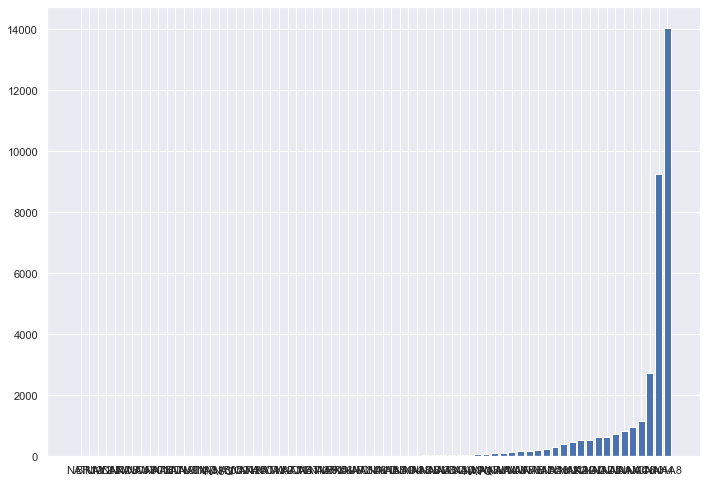

In [204]:
dfxc.info()
plt.bar(y_pos, dfxc["Values"])
plt.xticks(y_pos,dfxc["Name"]) 
plt.show()

## 3.6 Posting ID 

<a id='feature'></a>
# <b>4 Feature Selection


In [20]:
# First We will be starting with the dropping the different values that is not useful 
## that is 
x_train.head(5)

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,due_in_date,invoice_currency,document type,posting_id,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen,due_date,target
1,U001,0200980828,BEN E,2019-08-08,2019.0,1.929646e+09,2019-07-22,2019-07-22,2019-08-11,USD,RV,1.0,79656.60,2019-07-22,NAD1,1.929646e+09,0,2019-08-11,-3
2,U001,0200792734,MDV/ trust,2019-12-30,2019.0,1.929874e+09,2019-09-14,2019-09-14,2019-09-29,USD,RV,1.0,2253.86,2019-09-14,NAA8,1.929874e+09,0,2019-09-29,92
4,U001,0200769623,WAL-MAR foundation,2019-11-25,2019.0,1.930148e+09,2019-11-13,2019-11-13,2019-11-28,USD,RV,1.0,33133.29,2019-11-13,NAH4,1.930148e+09,0,2019-11-28,-3
5,CA02,0140106181,THE corporation,2019-12-04,2019.0,2.960581e+09,2019-09-20,2019-09-20,2019-10-04,CAD,RV,1.0,22225.84,2019-09-24,CA10,2.960581e+09,0,2019-10-04,61
6,U001,0200769623,WAL-MAR in,2019-11-12,2019.0,1.930083e+09,2019-11-01,2019-10-31,2019-11-16,USD,RV,1.0,7358.49,2019-11-01,NAH4,1.930083e+09,0,2019-11-16,-4


In [21]:
## Dropping the Column [Posting_ID , is_open, Document_type] since they are only one value 
x_train =  x_train.drop(['posting_id', 'posting_id', 'document type'], axis = 1)
x_test = x_test.drop(['posting_id', 'posting_id', 'document type'], axis = 1)

In [22]:
x_train.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,due_in_date,invoice_currency,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen,due_date,target
1,U001,0200980828,BEN E,2019-08-08,2019.0,1.929646e+09,2019-07-22,2019-07-22,2019-08-11,USD,79656.60,2019-07-22,NAD1,1.929646e+09,0,2019-08-11,-3
2,U001,0200792734,MDV/ trust,2019-12-30,2019.0,1.929874e+09,2019-09-14,2019-09-14,2019-09-29,USD,2253.86,2019-09-14,NAA8,1.929874e+09,0,2019-09-29,92
4,U001,0200769623,WAL-MAR foundation,2019-11-25,2019.0,1.930148e+09,2019-11-13,2019-11-13,2019-11-28,USD,33133.29,2019-11-13,NAH4,1.930148e+09,0,2019-11-28,-3
5,CA02,0140106181,THE corporation,2019-12-04,2019.0,2.960581e+09,2019-09-20,2019-09-20,2019-10-04,CAD,22225.84,2019-09-24,CA10,2.960581e+09,0,2019-10-04,61
6,U001,0200769623,WAL-MAR in,2019-11-12,2019.0,1.930083e+09,2019-11-01,2019-10-31,2019-11-16,USD,7358.49,2019-11-01,NAH4,1.930083e+09,0,2019-11-16,-4


In [23]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34971 entries, 1 to 49999
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   business_code         34971 non-null  object        
 1   cust_number           34971 non-null  object        
 2   name_customer         34971 non-null  object        
 3   clear_date            34971 non-null  datetime64[ns]
 4   buisness_year         34971 non-null  float64       
 5   doc_id                34971 non-null  float64       
 6   posting_date          34971 non-null  object        
 7   document_create_date  34971 non-null  datetime64[ns]
 8   due_in_date           34971 non-null  datetime64[ns]
 9   invoice_currency      34971 non-null  object        
 10  total_open_amount     34971 non-null  float64       
 11  baseline_create_date  34971 non-null  datetime64[ns]
 12  cust_payment_terms    34971 non-null  object        
 13  invoice_id      

In [24]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5023 entries, 0 to 49997
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   business_code         5023 non-null   object        
 1   cust_number           5023 non-null   object        
 2   name_customer         5023 non-null   object        
 3   clear_date            5023 non-null   datetime64[ns]
 4   buisness_year         5023 non-null   float64       
 5   doc_id                5023 non-null   float64       
 6   posting_date          5023 non-null   object        
 7   document_create_date  5023 non-null   datetime64[ns]
 8   due_in_date           5023 non-null   datetime64[ns]
 9   invoice_currency      5023 non-null   object        
 10  total_open_amount     5023 non-null   float64       
 11  baseline_create_date  5023 non-null   datetime64[ns]
 12  cust_payment_terms    5023 non-null   object        
 13  invoice_id       

## 4.1 Dealing With Date Formet
    * WE are gonna create a day and month from the Date Creating Column 
    


In [25]:
x_train["doc_create_day"] = x_train["document_create_date"].dt.day
x_train["doc_create_month"] = x_train["document_create_date"].dt.month

In [26]:
x_train["due_day"] =  x_train["due_in_date"].dt.day
x_train["due_month"] = x_train["due_in_date"].dt.month

In [27]:
x_test["doc_create_day"] = x_test["document_create_date"].dt.day
x_test["doc_create_month"] = x_test["document_create_date"].dt.month
x_test["due_day"] =  x_test["due_in_date"].dt.day
x_test["due_month"] = x_test["due_in_date"].dt.month

In [28]:
x_train = x_train

In [29]:
x_test = x_test

## 4.2 Dealing with Currency 

In [30]:
x_train['invoice_currency'] = x_train['invoice_currency'].map({'USD': 0,'CAD': 1})
x_test['invoice_currency'] = x_test['invoice_currency'].map({'USD': 0,'CAD': 1})

In [31]:
x_train

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,due_in_date,invoice_currency,...,baseline_create_date,cust_payment_terms,invoice_id,isOpen,due_date,target,doc_create_day,doc_create_month,due_day,due_month
1,U001,0200980828,BEN E,2019-08-08,2019.0,1.929646e+09,2019-07-22,2019-07-22,2019-08-11,0,...,2019-07-22,NAD1,1.929646e+09,0,2019-08-11,-3,22,7,11,8
2,U001,0200792734,MDV/ trust,2019-12-30,2019.0,1.929874e+09,2019-09-14,2019-09-14,2019-09-29,0,...,2019-09-14,NAA8,1.929874e+09,0,2019-09-29,92,14,9,29,9
4,U001,0200769623,WAL-MAR foundation,2019-11-25,2019.0,1.930148e+09,2019-11-13,2019-11-13,2019-11-28,0,...,2019-11-13,NAH4,1.930148e+09,0,2019-11-28,-3,13,11,28,11
5,CA02,0140106181,THE corporation,2019-12-04,2019.0,2.960581e+09,2019-09-20,2019-09-20,2019-10-04,1,...,2019-09-24,CA10,2.960581e+09,0,2019-10-04,61,20,9,4,10
6,U001,0200769623,WAL-MAR in,2019-11-12,2019.0,1.930083e+09,2019-11-01,2019-10-31,2019-11-16,0,...,2019-11-01,NAH4,1.930083e+09,0,2019-11-16,-4,31,10,16,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49991,U001,0200704045,RA trust,2019-10-25,2019.0,1.930001e+09,2019-10-10,2019-10-11,2019-10-25,0,...,2019-10-10,NAA8,1.930001e+09,0,2019-10-25,0,11,10,25,10
49994,U001,0200762301,C&S WH trust,2019-07-25,2019.0,1.929601e+09,2019-07-10,2019-07-09,2019-07-25,0,...,2019-07-10,NAC6,1.929601e+09,0,2019-07-25,0,9,7,25,7
49996,U001,0200769623,WAL-MAR co,2019-09-03,2019.0,1.929744e+09,2019-08-15,2019-08-14,2019-08-30,0,...,2019-08-15,NAH4,1.929744e+09,0,2019-08-30,4,14,8,30,8
49998,U001,0200726979,BJ'S llc,2019-12-12,2019.0,1.930199e+09,2019-11-27,2019-11-26,2019-12-12,0,...,2019-11-27,NAA8,1.930199e+09,0,2019-12-12,0,26,11,12,12


## 4.3 Dealing with the Name_customer and Cust_payment_terms 

In [32]:
# too much of classes hence not a option to include in the model as it will make it complicated 
# we will drop it later on 
x_train["name_customer"].value_counts()

WAL-MAR trust          821
WAL-MAR in             790
WAL-MAR                785
WAL-MAR corp           783
WAL-MAR corporation    773
                      ... 
SING associates          1
LAWR corporation         1
GEOR co                  1
COS in                   1
FOOD S                   1
Name: name_customer, Length: 3647, dtype: int64

In [33]:
x_train["cust_payment_terms"].value_counts()

NAA8    14032
NAH4     9267
CA10     2727
NAC6     1167
NAM4      947
        ...  
NATV        1
MC15        1
NAD8        1
NAV2        1
BR12        1
Name: cust_payment_terms, Length: 69, dtype: int64

In [34]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5023 entries, 0 to 49997
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   business_code         5023 non-null   object        
 1   cust_number           5023 non-null   object        
 2   name_customer         5023 non-null   object        
 3   clear_date            5023 non-null   datetime64[ns]
 4   buisness_year         5023 non-null   float64       
 5   doc_id                5023 non-null   float64       
 6   posting_date          5023 non-null   object        
 7   document_create_date  5023 non-null   datetime64[ns]
 8   due_in_date           5023 non-null   datetime64[ns]
 9   invoice_currency      5023 non-null   int64         
 10  total_open_amount     5023 non-null   float64       
 11  baseline_create_date  5023 non-null   datetime64[ns]
 12  cust_payment_terms    5023 non-null   object        
 13  invoice_id       

In [41]:
x_train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 34971 entries, 1 to 49999
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   business_code         34971 non-null  object        
 1   cust_number           34971 non-null  object        
 2   name_customer         34971 non-null  object        
 3   clear_date            34971 non-null  datetime64[ns]
 4   buisness_year         34971 non-null  float64       
 5   doc_id                34971 non-null  float64       
 6   posting_date          34971 non-null  object        
 7   document_create_date  34971 non-null  datetime64[ns]
 8   due_in_date           34971 non-null  datetime64[ns]
 9   invoice_currency      34971 non-null  int64         
 10  total_open_amount     34971 non-null  float64       
 11  baseline_create_date  34971 non-null  datetime64[ns]
 12  cust_payment_terms    34971 non-null  object        
 13  invoice_id      

In [42]:
# dropping all the unrequired featured 

x_train_final = x_train.drop(['doc_id', 'invoice_id','business_code', 'name_customer', 'clear_date',
                       'posting_date', 'document_create_date', 'baseline_create_date', 'cust_payment_terms',
                       'invoice_id', 'due_date', "due_in_date"], axis = 1)

In [43]:
x_test_final = x_test.drop(['doc_id', 'invoice_id','business_code', 'name_customer', 'clear_date',
                       'posting_date', 'document_create_date', 'baseline_create_date', 'cust_payment_terms',
                       'invoice_id', 'due_date',"due_in_date"], axis = 1)

In [44]:
x_test_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5023 entries, 0 to 49997
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   cust_number        5023 non-null   object 
 1   buisness_year      5023 non-null   float64
 2   invoice_currency   5023 non-null   int64  
 3   total_open_amount  5023 non-null   float64
 4   isOpen             5023 non-null   int64  
 5   target             5023 non-null   int64  
 6   doc_create_day     5023 non-null   int64  
 7   doc_create_month   5023 non-null   int64  
 8   due_day            5023 non-null   int64  
 9   due_month          5023 non-null   int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 431.7+ KB


In [45]:
x_train_final["cust"] = x_train_final['cust_number'].str.extract('(\d+)')
x_train_final["cust"]=x_train_final["cust"].apply(int)

In [46]:
x_train_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34971 entries, 1 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   cust_number        34971 non-null  object 
 1   buisness_year      34971 non-null  float64
 2   invoice_currency   34971 non-null  int64  
 3   total_open_amount  34971 non-null  float64
 4   isOpen             34971 non-null  int64  
 5   target             34971 non-null  int64  
 6   doc_create_day     34971 non-null  int64  
 7   doc_create_month   34971 non-null  int64  
 8   due_day            34971 non-null  int64  
 9   due_month          34971 non-null  int64  
 10  cust               34971 non-null  int64  
dtypes: float64(2), int64(8), object(1)
memory usage: 3.2+ MB


In [49]:
x_test_final["cust"] = x_test_final['cust_number'].str.extract('(\d+)')
x_test_final["cust"]=x_train_final["cust"].apply(int)

In [50]:
x_test_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5023 entries, 0 to 49997
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   cust_number        5023 non-null   object 
 1   buisness_year      5023 non-null   float64
 2   invoice_currency   5023 non-null   int64  
 3   total_open_amount  5023 non-null   float64
 4   isOpen             5023 non-null   int64  
 5   target             5023 non-null   int64  
 6   doc_create_day     5023 non-null   int64  
 7   doc_create_month   5023 non-null   int64  
 8   due_day            5023 non-null   int64  
 9   due_month          5023 non-null   int64  
 10  cust               0 non-null      float64
dtypes: float64(3), int64(7), object(1)
memory usage: 470.9+ KB


In [52]:
x_train_final= x_train_final.drop(["cust_number"], axis= 1)
x_test_final= x_test_final.drop(["cust_number"], axis= 1)

## 4.10 Splitting the Final Data 


In [53]:
y_train_final1 =  x_train_final["target"]
x_train_final1 = x_train_final.drop(["target"],axis =1) 

In [54]:
print(y_train_final1.info())
print(x_train_final1.info())

<class 'pandas.core.series.Series'>
Int64Index: 34971 entries, 1 to 49999
Series name: target
Non-Null Count  Dtype
--------------  -----
34971 non-null  int64
dtypes: int64(1)
memory usage: 1.5 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 34971 entries, 1 to 49999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   buisness_year      34971 non-null  float64
 1   invoice_currency   34971 non-null  int64  
 2   total_open_amount  34971 non-null  float64
 3   isOpen             34971 non-null  int64  
 4   doc_create_day     34971 non-null  int64  
 5   doc_create_month   34971 non-null  int64  
 6   due_day            34971 non-null  int64  
 7   due_month          34971 non-null  int64  
 8   cust               34971 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 3.7 MB
None


In [55]:
x_train_final1 = x_train_final1.drop(["customer_number"], axis =1)


KeyError: "['customer_number'] not found in axis"

In [57]:
x_train_final1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34971 entries, 1 to 49999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   buisness_year      34971 non-null  float64
 1   invoice_currency   34971 non-null  int64  
 2   total_open_amount  34971 non-null  float64
 3   isOpen             34971 non-null  int64  
 4   doc_create_day     34971 non-null  int64  
 5   doc_create_month   34971 non-null  int64  
 6   due_day            34971 non-null  int64  
 7   due_month          34971 non-null  int64  
 8   cust               34971 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 3.7 MB


In [58]:
Xtrain ,Xtest, ytrain, ytest = train_test_split(x_train_final1, y_train_final1, test_size = 0.3, random_state=0)

 <a id='ml'></a>
# <b> 5 ML MODEL </b>
   
        1.  Linear Regression
        2.  Support Vector Regression
        3.  Decision Tree Regression
        4.  Random Forest Regressor 
        5. XG BOOST
 

In [1]:
MSE_Score = []
R2_Score = []
Algorithm = []

### <b>5.1 Linear Regreesion </b>

In [60]:
Algorithm.append('Linear Regression')
model = LinearRegression()
model.fit(Xtrain, ytrain)
predicted =model.predict(Xtest)
MSE_Score.append(metrics.mean_squared_error(ytest, predicted))
R2_Score.append(metrics.r2_score(ytest, predicted))

### <b>5.2 Random Forest Regression </b>

In [61]:
Algorithm.append('Random Forest Regression')
model1 = RandomForestRegressor()
model1.fit(Xtrain, ytrain)
predicted =model1.predict(Xtest)
MSE_Score.append(metrics.mean_squared_error(ytest, predicted))
R2_Score.append(metrics.r2_score(ytest, predicted))

### <b> 5.3 Support Vector Regression</b>

In [65]:
Algorithm.append('Support Vector Regression')
model2 = SVR()
model2.fit(Xtrain, ytrain)
predicted =model2.predict(Xtest)
MSE_Score.append(metrics.mean_squared_error(ytest, predicted))
R2_Score.append(metrics.r2_score(ytest, predicted))

### <b> 5.4 Decision Tree Regressor</b>

In [66]:
Algorithm.append('Decision Tree Regressor')
model3 = DecisionTreeRegressor()
model3.fit(Xtrain, ytrain)
predicted =model3.predict(Xtest)
MSE_Score.append(metrics.mean_squared_error(ytest, predicted))
R2_Score.append(metrics.r2_score(ytest, predicted))

### <b> 5.5 XG Boost </b>

In [67]:
Algorithm.append("XG Boost ")
model4 = xg.XGBRegressor()
model4.fit(Xtrain, ytrain)
predicted =model4.predict(Xtest)
MSE_Score.append(metrics.mean_squared_error(ytest, predicted))
R2_Score.append(metrics.r2_score(ytest, predicted))

e:\conda\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [80]:
Comparison = pd.DataFrame(list(zip(Algorithm, MSE_Score, R2_Score)), columns = ['Algorithm', 'MSE_Score', 'R2_Score'])

In [81]:
Comparison

,Algorithm,MSE_Score,R2_Score
0,Linear Regression,91.237682,0.157340
1,Random Forest Regression,62.889532,0.419160
2,Support Vector Regression,90.692141,0.162379
3,Decision Tree Regressor,124.098181,-0.146155
4,XG Boost,63.020793,0.417948


In [ ]:
# overall the model is not improving by doing multiple EDA and Feature Engineering 

# <b> 6  Model Selection</b>

1. Basically we tried each model but got the best accuracy in the Radom Forest and XG BOOST  Hence we will choose these for our purpose 

# <b> 7  HYPERPARAMETER TUNNING </b>

* 1. For Random Forest 
* 2. For XG Boost 

In [72]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

# Create a base model
rf = RandomForestRegressor(random_state = 42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)

In [73]:
grid_search.fit(Xtrain, ytrain);

Fitting 3 folds for each of 288 candidates, totalling 864 fits


In [74]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 200}

In [78]:
rf2 = RandomForestRegressor(bootstrap= True,
 max_depth= 80,
 max_features= 3,
 min_samples_leaf= 3,
 min_samples_split= 10,
 n_estimators= 200)

In [79]:
rf2.fit(Xtrain, ytrain)
predicted =rf2.predict(Xtest)
MSE_Score.append(metrics.mean_squared_error(ytest, predicted))
R2_Score.append(metrics.r2_score(ytest, predicted))

In [82]:
Comparison = pd.DataFrame(list(zip(Algorithm, MSE_Score, R2_Score)), columns = ['Algorithm', 'MSE_Score', 'R2_Score'])

In [83]:
MSE_Score

[91.23768166808561,
 62.889532295209214,
 90.69214133724256,
 124.09818062439106,
 63.02079262943133,
 62.051132287985645]

In [85]:
R2_Score

[0.1573401869882397,
 0.4191601479192867,
 0.16237872923058805,
 -0.14615527014895502,
 0.4179478438945763,
 0.4269035054925995]